In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
dti_folder = "/biodata/nyanovsky/datasets/dti/processed/"

In [4]:
import pickle
G = pickle.load(open(dti_folder+"dti_graph.pickle",'rb'))

In [5]:
def get_rel_subgraph(G: nx.Graph, rel: str) -> nx.Graph:
    rel_edges = [(u,v) for (u,v,r_dict) in G.edges.data() if r_dict["edge_type"]==rel]
    rel_subgraph = G.edge_subgraph(rel_edges).copy()
    return rel_subgraph

In [6]:
ChG_subgraph = get_rel_subgraph(G, "chg")
ChCh_subgraph = get_rel_subgraph(G, "chch")
GG_subgraph = get_rel_subgraph(G, "gg")

In [7]:
from collections import Counter
plt.style.use("ggplot")

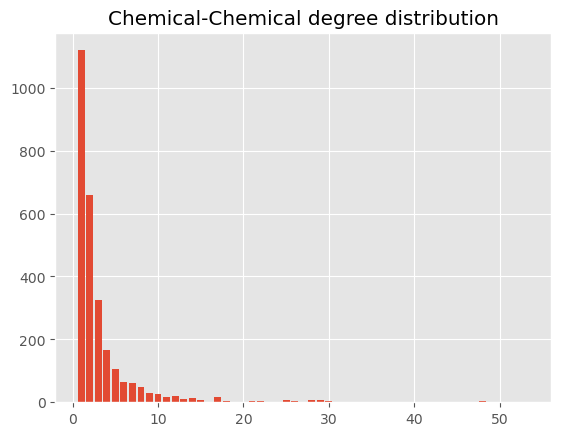

In [8]:
ChCh_degs = [deg for node, deg in ChCh_subgraph.degree()]
deg, counts = zip(*Counter(ChCh_degs).items())
plt.bar(deg,counts)
plt.title("Chemical-Chemical degree distribution")
plt.show()

In [13]:
sorted(ChCh_subgraph.degree(), key=lambda x:x[1], reverse=True)

[('C6083', 53),
 ('C6022', 52),
 ('C5957', 51),
 ('C440317', 48),
 ('C440210', 48),
 ('C128882', 48),
 ('C447048', 45),
 ('C33113', 43),
 ('C91532', 43),
 ('C91557', 41),
 ('C10238', 41),
 ('C60961', 40),
 ('C448894', 37),
 ('C447049', 37),
 ('C448505', 36),
 ('C21704', 32),
 ('C159296', 32),
 ('C444493', 30),
 ('C174251', 30),
 ('C122283', 30),
 ('C10214', 30),
 ('C165390', 30),
 ('C135815451', 29),
 ('C644065', 29),
 ('C446090', 29),
 ('C87642', 29),
 ('C449118', 29),
 ('C92153', 29),
 ('C5289039', 29),
 ('C448875', 28),
 ('C3081439', 28),
 ('C11966124', 28),
 ('C449575', 28),
 ('C445344', 28),
 ('C164800', 28),
 ('C448575', 28),
 ('C444451', 27),
 ('C165230', 27),
 ('C447877', 26),
 ('C44229079', 26),
 ('C445461', 26),
 ('C449362', 26),
 ('C163872', 25),
 ('C444837', 25),
 ('C446814', 25),
 ('C5497113', 25),
 ('C439153', 25),
 ('C446811', 25),
 ('C440141', 25),
 ('C165491', 24),
 ('C439176', 24),
 ('C17753791', 23),
 ('C6858209', 23),
 ('C135415790', 22),
 ('C131704262', 22),
 ('C44

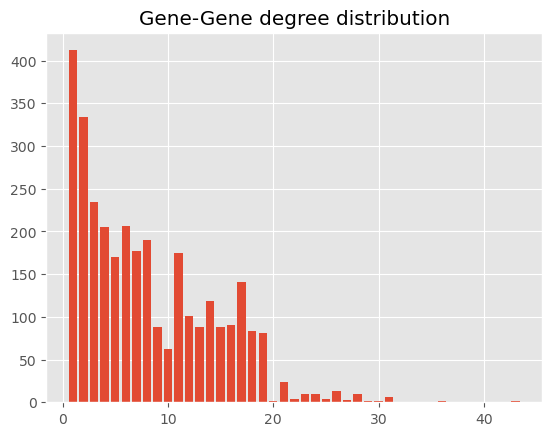

In [9]:
GG_degs = [deg for node, deg in GG_subgraph.degree()]
deg, counts = zip(*Counter(GG_degs).items())
plt.bar(deg,counts)
plt.title("Gene-Gene degree distribution")
plt.show()

In [14]:
sorted(GG_subgraph.degree(), key=lambda x:x[1], reverse=True)

[('G375790', 43),
 ('G2621', 36),
 ('G6285', 31),
 ('G795', 31),
 ('G6282', 31),
 ('G6271', 31),
 ('G5775', 31),
 ('G10507', 31),
 ('G825', 30),
 ('G5651', 30),
 ('G53905', 29),
 ('G50506', 29),
 ('G716', 28),
 ('G51592', 28),
 ('G9757', 28),
 ('G25891', 28),
 ('G2550', 28),
 ('G715', 28),
 ('G729', 28),
 ('G10747', 28),
 ('G4301', 28),
 ('G4297', 28),
 ('G177', 27),
 ('G8805', 27),
 ('G3339', 27),
 ('G2289', 26),
 ('G7082', 26),
 ('G4313', 26),
 ('G10461', 26),
 ('G2209', 26),
 ('G5803', 26),
 ('G4318', 26),
 ('G4636', 26),
 ('G7173', 26),
 ('G1108', 26),
 ('G51314', 26),
 ('G5536', 26),
 ('G5793', 26),
 ('G4916', 25),
 ('G3909', 25),
 ('G3908', 25),
 ('G8482', 25),
 ('G79633', 24),
 ('G23239', 24),
 ('G29994', 24),
 ('G58508', 24),
 ('G3911', 24),
 ('G79400', 24),
 ('G5627', 24),
 ('G4360', 24),
 ('G8085', 24),
 ('G54437', 24),
 ('G6453', 23),
 ('G1462', 23),
 ('G3984', 23),
 ('G176', 23),
 ('G93349', 23),
 ('G344805', 23),
 ('G3985', 23),
 ('G6768', 23),
 ('G1463', 23),
 ('G9124', 2

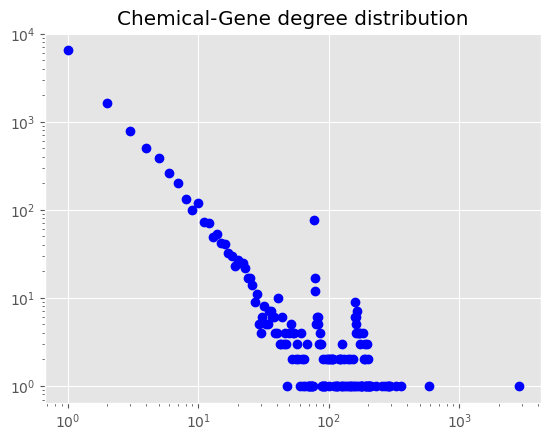

In [10]:
ChG_degs = [deg for node, deg in ChG_subgraph.degree()]
deg, counts = zip(*Counter(ChG_degs).items())
plt.loglog(deg,counts, "bo")
plt.title("Chemical-Gene degree distribution")
plt.show()

In [15]:
sorted(ChG_subgraph.degree(), key=lambda x:x[1], reverse=True)
# el de 2840 es Ca[2+], tiene sentido tener iones como compuestos?
# el top 3 de proteinas son citocromos p450, conviene mergearlos en un solo nodo?

[('C271', 2840),
 ('G1576', 587),
 ('C14290', 356),
 ('G1565', 330),
 ('G1559', 296),
 ('G2099', 287),
 ('C23978', 286),
 ('C544', 284),
 ('G1544', 271),
 ('C5329102', 257),
 ('G1557', 230),
 ('C2801', 211),
 ('C2818', 206),
 ('C2160', 205),
 ('C4543', 203),
 ('C2170', 202),
 ('C3715', 200),
 ('C3696', 200),
 ('C2520', 198),
 ('C2995', 196),
 ('C5002', 196),
 ('C4095', 196),
 ('C2726', 195),
 ('C3559', 194),
 ('C2771', 192),
 ('C2585', 191),
 ('C3386', 191),
 ('C4585', 191),
 ('C4205', 190),
 ('G1558', 189),
 ('C4449', 189),
 ('C4168', 186),
 ('C36811', 186),
 ('C60795', 183),
 ('C5533', 183),
 ('C5656', 183),
 ('C3158', 183),
 ('G367', 181),
 ('G1577', 180),
 ('C125017', 178),
 ('C5073', 176),
 ('C3964', 173),
 ('C3827', 173),
 ('C4927', 173),
 ('C4917', 173),
 ('C5090', 172),
 ('C4748', 172),
 ('C3961', 172),
 ('G1813', 170),
 ('C2803', 170),
 ('C4011', 170),
 ('C3372', 170),
 ('C4946', 169),
 ('G8856', 166),
 ('C2764', 166),
 ('C3749', 166),
 ('C4893', 166),
 ('C115237', 165),
 ('C2

Veamos transitividad en la red, i.e cuantos triangulos se cierran de la forma Ch-Ch-G o G-G-Ch (Quiero ver si compuestos similares se pegan a las mismas proteinas, o si proteinas similares son targeteadas por el mismo compuesto) (Tiene sentido mirar cierres de cuadrados de la forma G-Ch-Ch-G o Ch-G-G-Ch ?)

In [19]:
def ChG_triangles(ChG_net):
    ChG_triangles = 0
    for u,v in ChG_net.edges():
        if u.startswith("C") and v.startswith("G"):
            chem, gene = u,v 
        else:
            chem, gene = v,u
        if chem in ChCh_subgraph.nodes():
            chem_neighs = ChCh_subgraph.neighbors(chem)
            for neigh in chem_neighs:
                if (neigh, gene) in ChG_net.edges() or (gene, neigh) in ChG_net.edges():
                    ChG_triangles += 1
        if gene in GG_subgraph.nodes():
            gene_neighs = GG_subgraph.neighbors(gene)
            for neigh in gene_neighs:
                if (neigh, chem) in ChG_net.edges() or (chem, neigh) in ChG_net.edges():
                    ChG_triangles += 1
    return ChG_triangles

In [17]:
ChG_connected_triplets = 0
for node in ChG_subgraph.nodes():
    if node in ChCh_subgraph.nodes() or node in GG_subgraph.nodes(): 
        # hay nodos de altisimo grado (como el Ca2+, o los citocromos) que no tienen conexiones con otras drogas/proteinas, 
        # no le veo sentido contar los posibles tripletes que puedan formar. 
        ChG_connected_triplets += len(set(ChG_subgraph.neighbors(node))) * (len(set(ChG_subgraph.neighbors(node)))-1)/2

        # esto funciona porque el subgrafo es bipartito, nunca se cuentan tripletes dos veces

In [20]:
valor_real = ChG_triangles(ChG_subgraph)/ChG_connected_triplets

In [21]:
ChG_subgraph.number_of_edges()

38391

In [31]:
import concurrent.futures

In [39]:
np.random.random_integers

array([0.50597632, 0.24980219, 0.5224674 , 0.81404635, 0.68715095,
       0.2991597 , 0.96106821, 0.17866913, 0.8401235 , 0.44121977])

In [41]:
ChG_net = ChG_subgraph.copy()
def calc_triangle_coef(ChG_net):
    net = ChG_net.copy()
    nx.double_edge_swap(net,38000, 100000)
    return ChG_triangles(net)/ChG_connected_triplets

In [42]:
num_cores = 12
reps = 1000
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(calc_triangle_coef, [ChG_net] * reps))

frac_triangulos = results

In [46]:
np.diff(np.unique(frac_triangulos))

array([1.69665984e-05, 3.25193136e-05, 7.77635761e-06, 2.82776640e-06,
       9.19024081e-06, 7.06941601e-06, 2.82776640e-06, 1.62596568e-05,
       2.82776640e-06, 1.41388320e-06, 9.19024081e-06, 2.12082480e-06,
       3.53470800e-06, 7.06941601e-07, 2.12082480e-06, 7.06941601e-07,
       2.12082480e-06, 7.06941601e-07, 7.06941601e-06, 1.41388320e-06,
       1.41388320e-06, 1.41388320e-06, 1.41388320e-06, 2.12082480e-06,
       1.41388320e-06, 5.65553281e-06, 2.82776640e-06, 4.94859121e-06,
       4.24164961e-06, 2.82776640e-06, 7.06941601e-07, 1.41388320e-06,
       3.53470800e-06, 7.06941601e-07, 1.41388320e-06, 7.06941601e-07,
       1.41388320e-06, 7.06941601e-07, 2.12082480e-06, 7.06941601e-07,
       1.41388320e-06, 1.41388320e-06, 7.06941601e-06, 2.82776640e-06,
       7.06941601e-07, 7.06941601e-07, 7.06941601e-07, 3.53470800e-06,
       1.41388320e-06, 1.41388320e-06, 1.41388320e-06, 7.06941601e-07,
       7.06941601e-07, 7.06941601e-07, 2.12082480e-06, 2.82776640e-06,
      

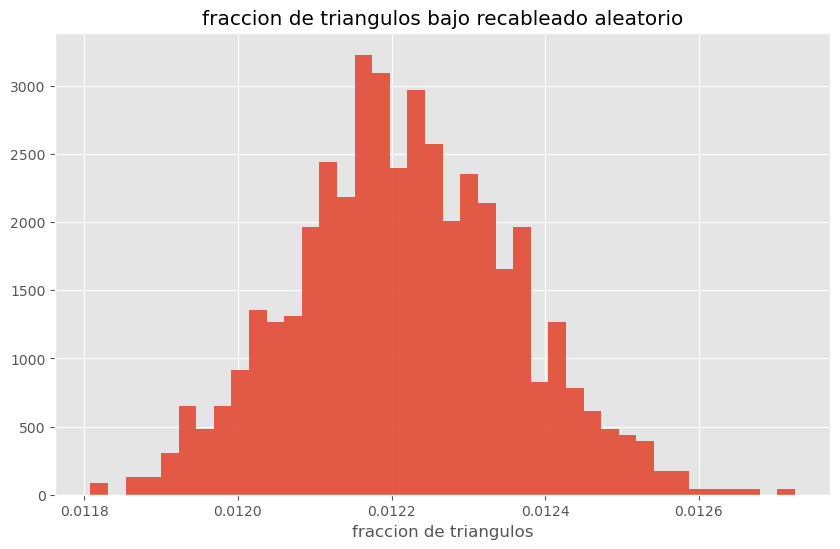

In [68]:
fig = plt.figure(figsize=(10,6))
plt.hist(frac_triangulos, bins=40, density=True,alpha=0.9)
plt.title("fraccion de triangulos bajo recableado aleatorio")
plt.xlabel("fraccion de triangulos")
plt.show()

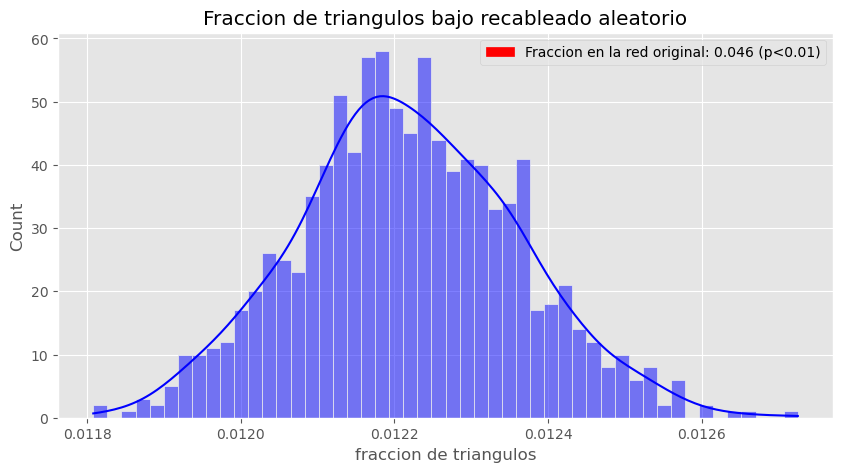

In [89]:
import seaborn as sns
from matplotlib.patches import Patch
custom_legend = [Patch(color='red', label=f'Fraccion en la red original: {valor_real:.3f} (p<0.01)')]

plt.figure(figsize=(10,5))
sns.histplot(frac_triangulos, bins=50, kde=True, color="blue",alpha=0.5)
plt.title("Fraccion de triangulos bajo recableado aleatorio")
plt.xlabel("fraccion de triangulos")
plt.legend(handles=custom_legend, loc="upper right")